In [67]:
import pandas as pd

# Load the data from the uploaded files
file_paths = {
    "renewable_energy_difference": "/Users/RayhanZirvi/Desktop/renewable_energy_difference.csv",
    "sentiment_regress": "/Users/RayhanZirvi/Desktop/sentiment_regress.csv",
    "socio_regress": "/Users/RayhanZirvi/Desktop/socio_regress.csv"
}

# Read the files into pandas DataFrames
dfs = {name: pd.read_csv(path) for name, path in file_paths.items()}

# Display the first few rows of each DataFrame to understand their structure
for name, df in dfs.items():
    print(f"First few rows of {name}:")
    print(df.head(), "\n")

First few rows of renewable_energy_difference:
  State  percentage_renewable_produced  percentage_renewable_consumed  \
0    AK                          28.19                       3.777823   
1    AL                          10.74                      14.368555   
2    AR                           8.89                      10.895120   
3    AZ                          13.43                      12.462193   
4    CA                          41.05                      24.971704   

   difference  
0   24.412177  
1   -3.628555  
2   -2.005120  
3    0.967807  
4   16.078296   

First few rows of sentiment_regress:
  State  Drill    co2  drill_diff  co2_diff
0    AL  61.39  67.15   10.762353 -3.742157
1    AK  48.40  69.14   -2.227647 -1.752157
2    AZ  52.80  71.21    2.172353  0.317843
3    AR  55.77  67.11    5.142353 -3.782157
4    CA  39.44  74.12  -11.187647  3.227843 

First few rows of socio_regress:
  State Per_Capita_Income  Poverty_Percentage  Unemployment_Rate  \
0    AL     

In [68]:
# Before merging, we need to clean and prepare the socio_regress data
# Specifically, converting the income, carpool estimate, self-employment estimate,
# and social security estimate columns to numeric, as they seem to be formatted as strings with commas.

socio_regress_df = dfs['socio_regress'].copy()

# Columns to convert
columns_to_convert = ['Per_Capita_Income', 'Carpool_Estimate', 'Self-Employ_Estimate', 'Social_Security_Estimate']

# Remove commas and convert to numeric
for column in columns_to_convert:
    socio_regress_df[column] = pd.to_numeric(socio_regress_df[column].str.replace(',', ''), errors='coerce')

# Merge the datasets on the State column
merged_df = dfs['sentiment_regress'].merge(dfs['renewable_energy_difference'], on='State', how='inner')
merged_df = merged_df.merge(socio_regress_df, on='State', how='inner')

# Checking the merged DataFrame to ensure it looks correct
print(merged_df.head())
print("\nColumns in merged dataset:", merged_df.columns)

  State  Drill    co2  drill_diff  co2_diff  percentage_renewable_produced  \
0    AL  61.39  67.15   10.762353 -3.742157                          10.74   
1    AK  48.40  69.14   -2.227647 -1.752157                          28.19   
2    AZ  52.80  71.21    2.172353  0.317843                          13.43   
3    AR  55.77  67.11    5.142353 -3.782157                           8.89   
4    CA  39.44  74.12  -11.187647  3.227843                          41.05   

   percentage_renewable_consumed  difference  Per_Capita_Income  \
0                      14.368555   -3.628555              30458   
1                       3.777823   24.412177              39236   
2                      12.462193    0.967807              34644   
3                      10.895120   -2.005120              29210   
4                      24.971704   16.078296              41276   

   Poverty_Percentage  Unemployment_Rate  Carpool_Estimate  Work_Estimate  \
0                15.8           5.400697           

In [69]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the dependent variable (target) and independent variables (features)
target = 'co2_diff'
features = [
    'difference',
    'Per_Capita_Income',
    'Carpool_Estimate',
    'Unemployment_Rate',
    'Work_Estimate',  # Assuming this represents the mean travel time as described
    'Education_Estimate',  # Assuming this represents percent bachelors degree as described
    'Married_Percent',
    'Self-Employ_Estimate',
    'Social_Security_Estimate'
]

X = merged_df[features]
y = merged_df[target]

# Convert 'Per_Capita_Income' from string to float for regression analysis
X['Per_Capita_Income'] = X['Per_Capita_Income'].astype(float)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Use .loc to avoid SettingWithCopyWarning
X.loc[:, 'Per_Capita_Income'] = X['Per_Capita_Income'].astype(float)

# Initialize and train the Gradient Boosting Regressor
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Feature importances and intercept (not available for GradientBoostingRegressor)
feature_importances = model.feature_importances_

mse, rmse, r2, feature_importances

/var/folders/mn/0wndgtfd13nf28t24tfh3zzr0000gn/T/ipykernel_27913/2579702380.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Per_Capita_Income'] = X['Per_Capita_Income'].astype(float)


(5.333633714218287,
 2.3094661102121172,
 0.6734883457484692,
 array([0.03019943, 0.57765442, 0.01705819, 0.02578202, 0.09626115,
        0.05333058, 0.02585952, 0.17009439, 0.00376032]))

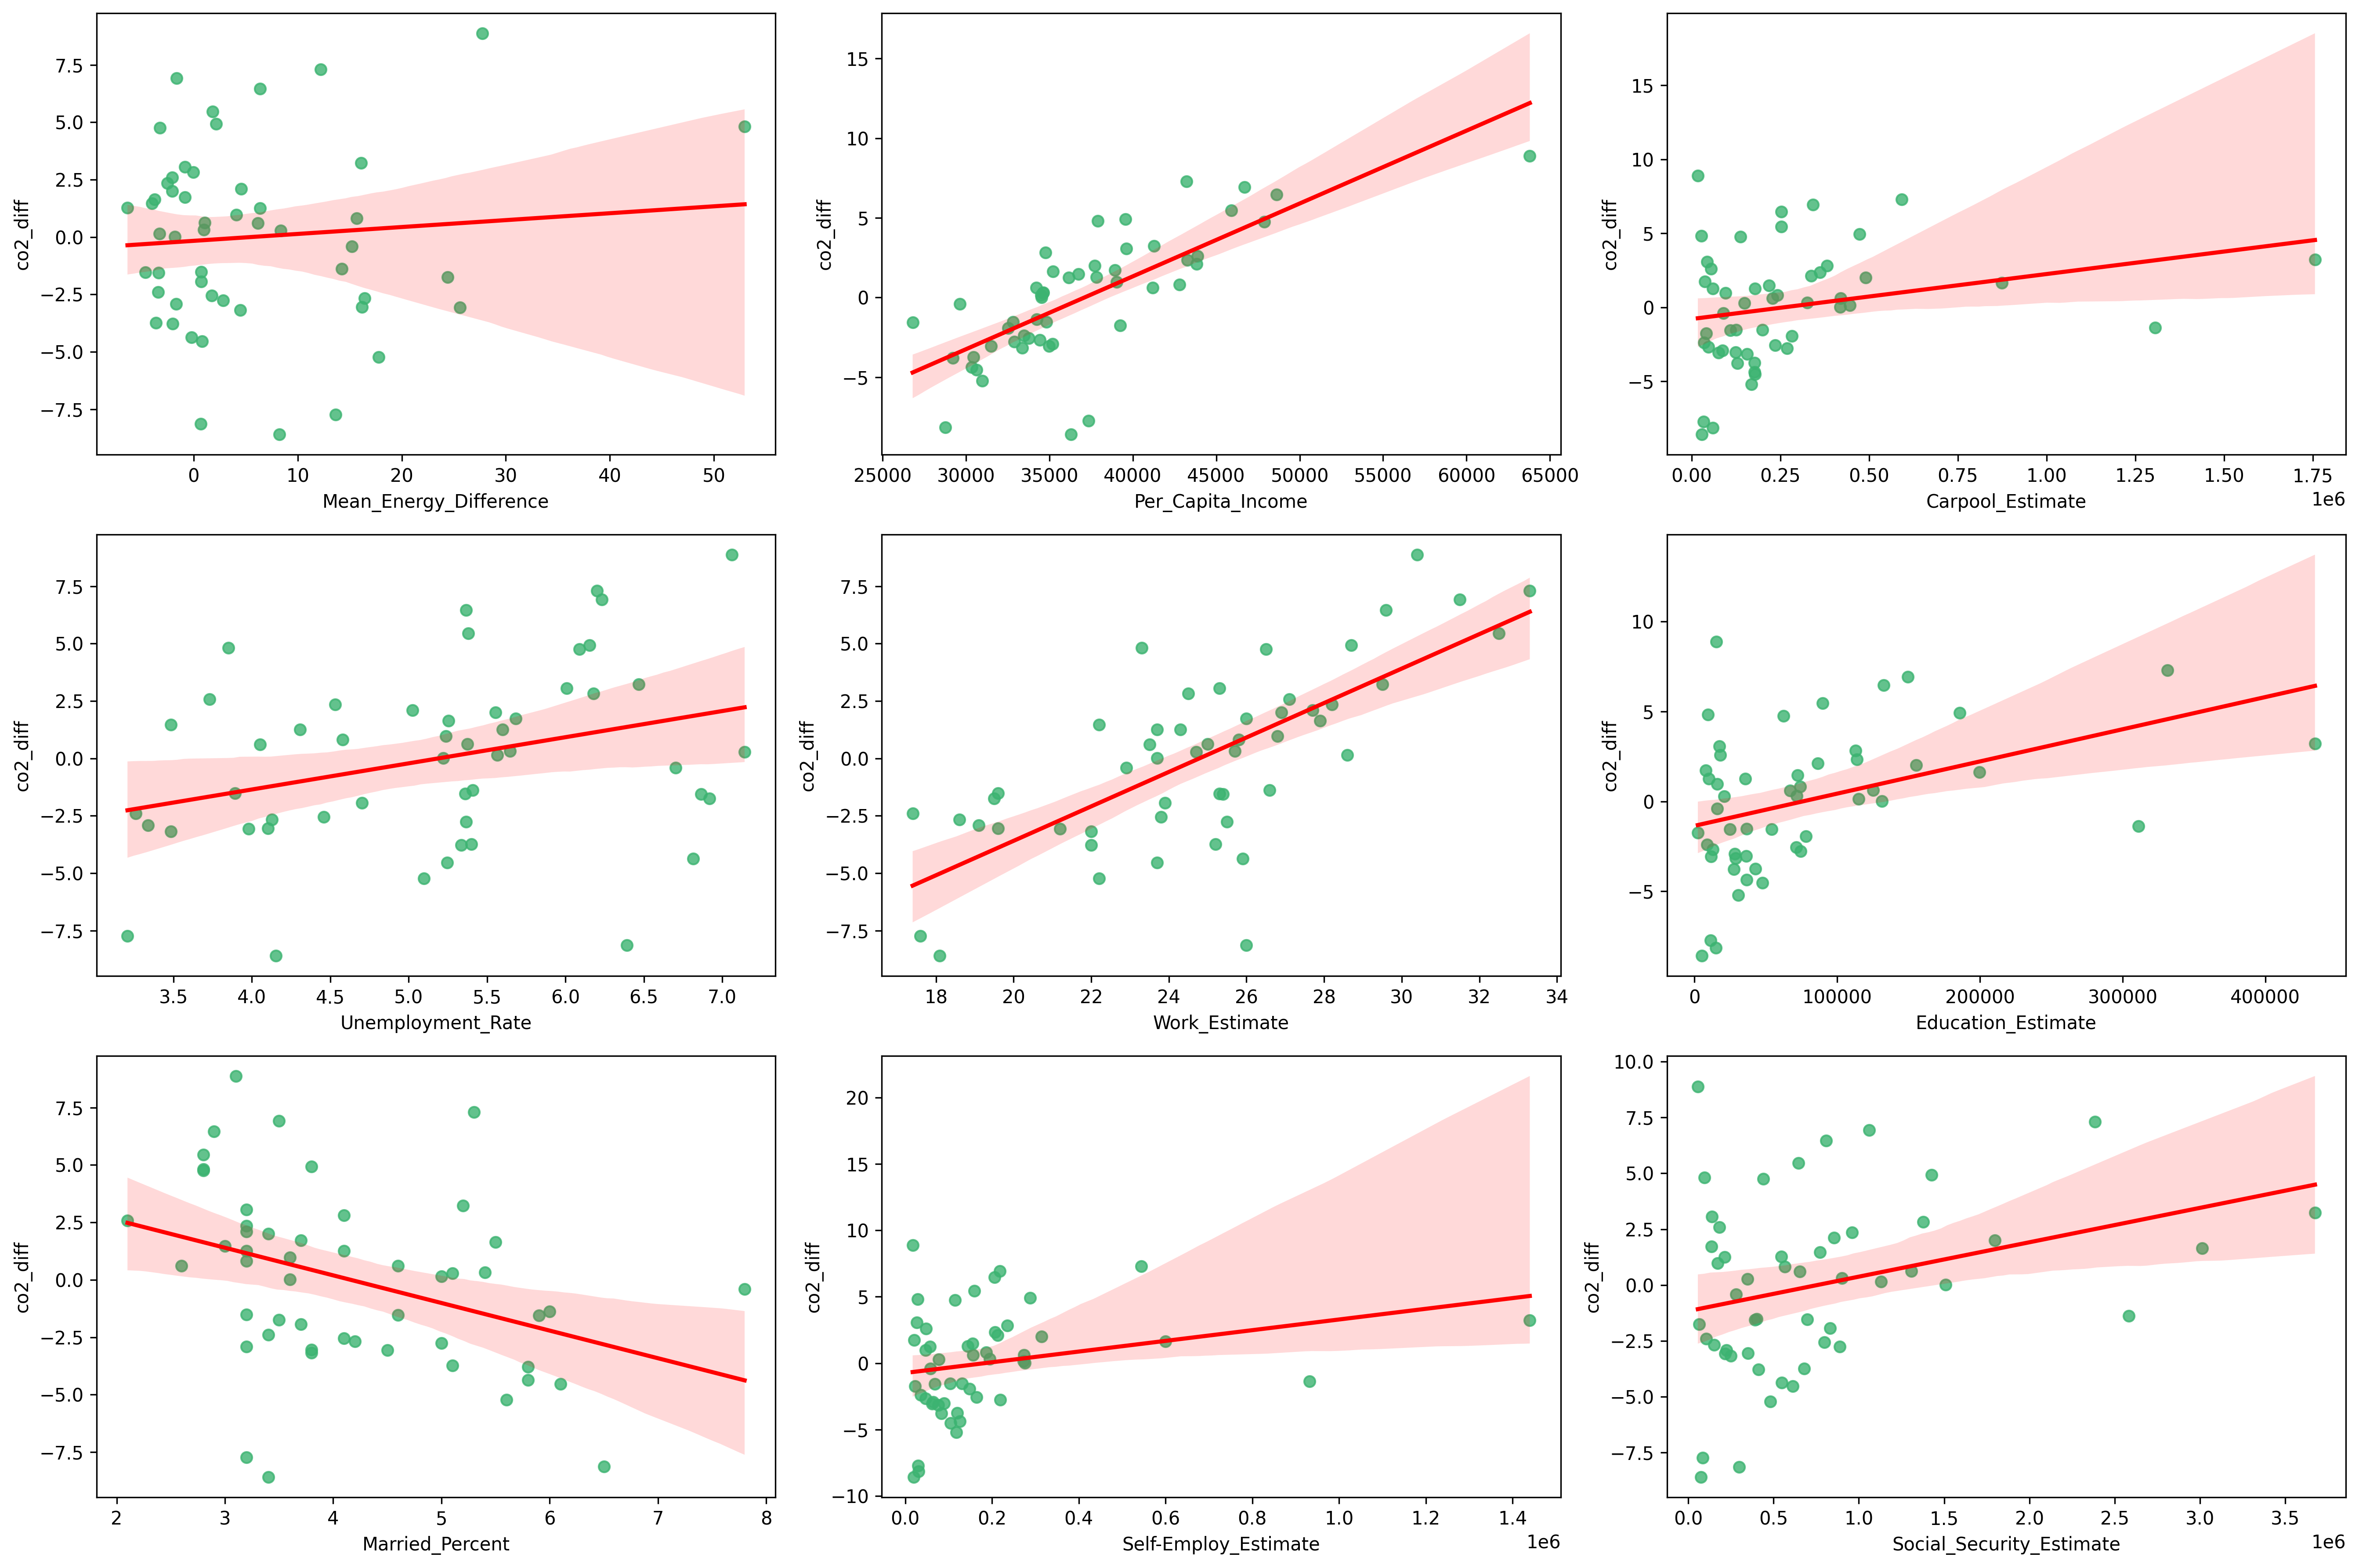

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting multiple linear regressions using seaborn's pairplot
# We will create a new DataFrame that includes the dependent variable and the independent variables
plot_data = X.copy()
plot_data[target] = y

# Adjusting the size of the plots to make them larger and organizing them into rows of 3 for better visibility
plt.figure(figsize=(18, 12), dpi=300)

# Since there are 9 features, we'll organize them into 3 rows of 3 plots each
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.regplot(x=feature, y=target, data=plot_data, line_kws={"color": "red"}, scatter_kws={"color": "mediumseagreen"})
    if feature == 'difference':
        plt.xlabel("Mean_Energy_Difference")
    # plt.title(feature)

plt.tight_layout()
plt.show()

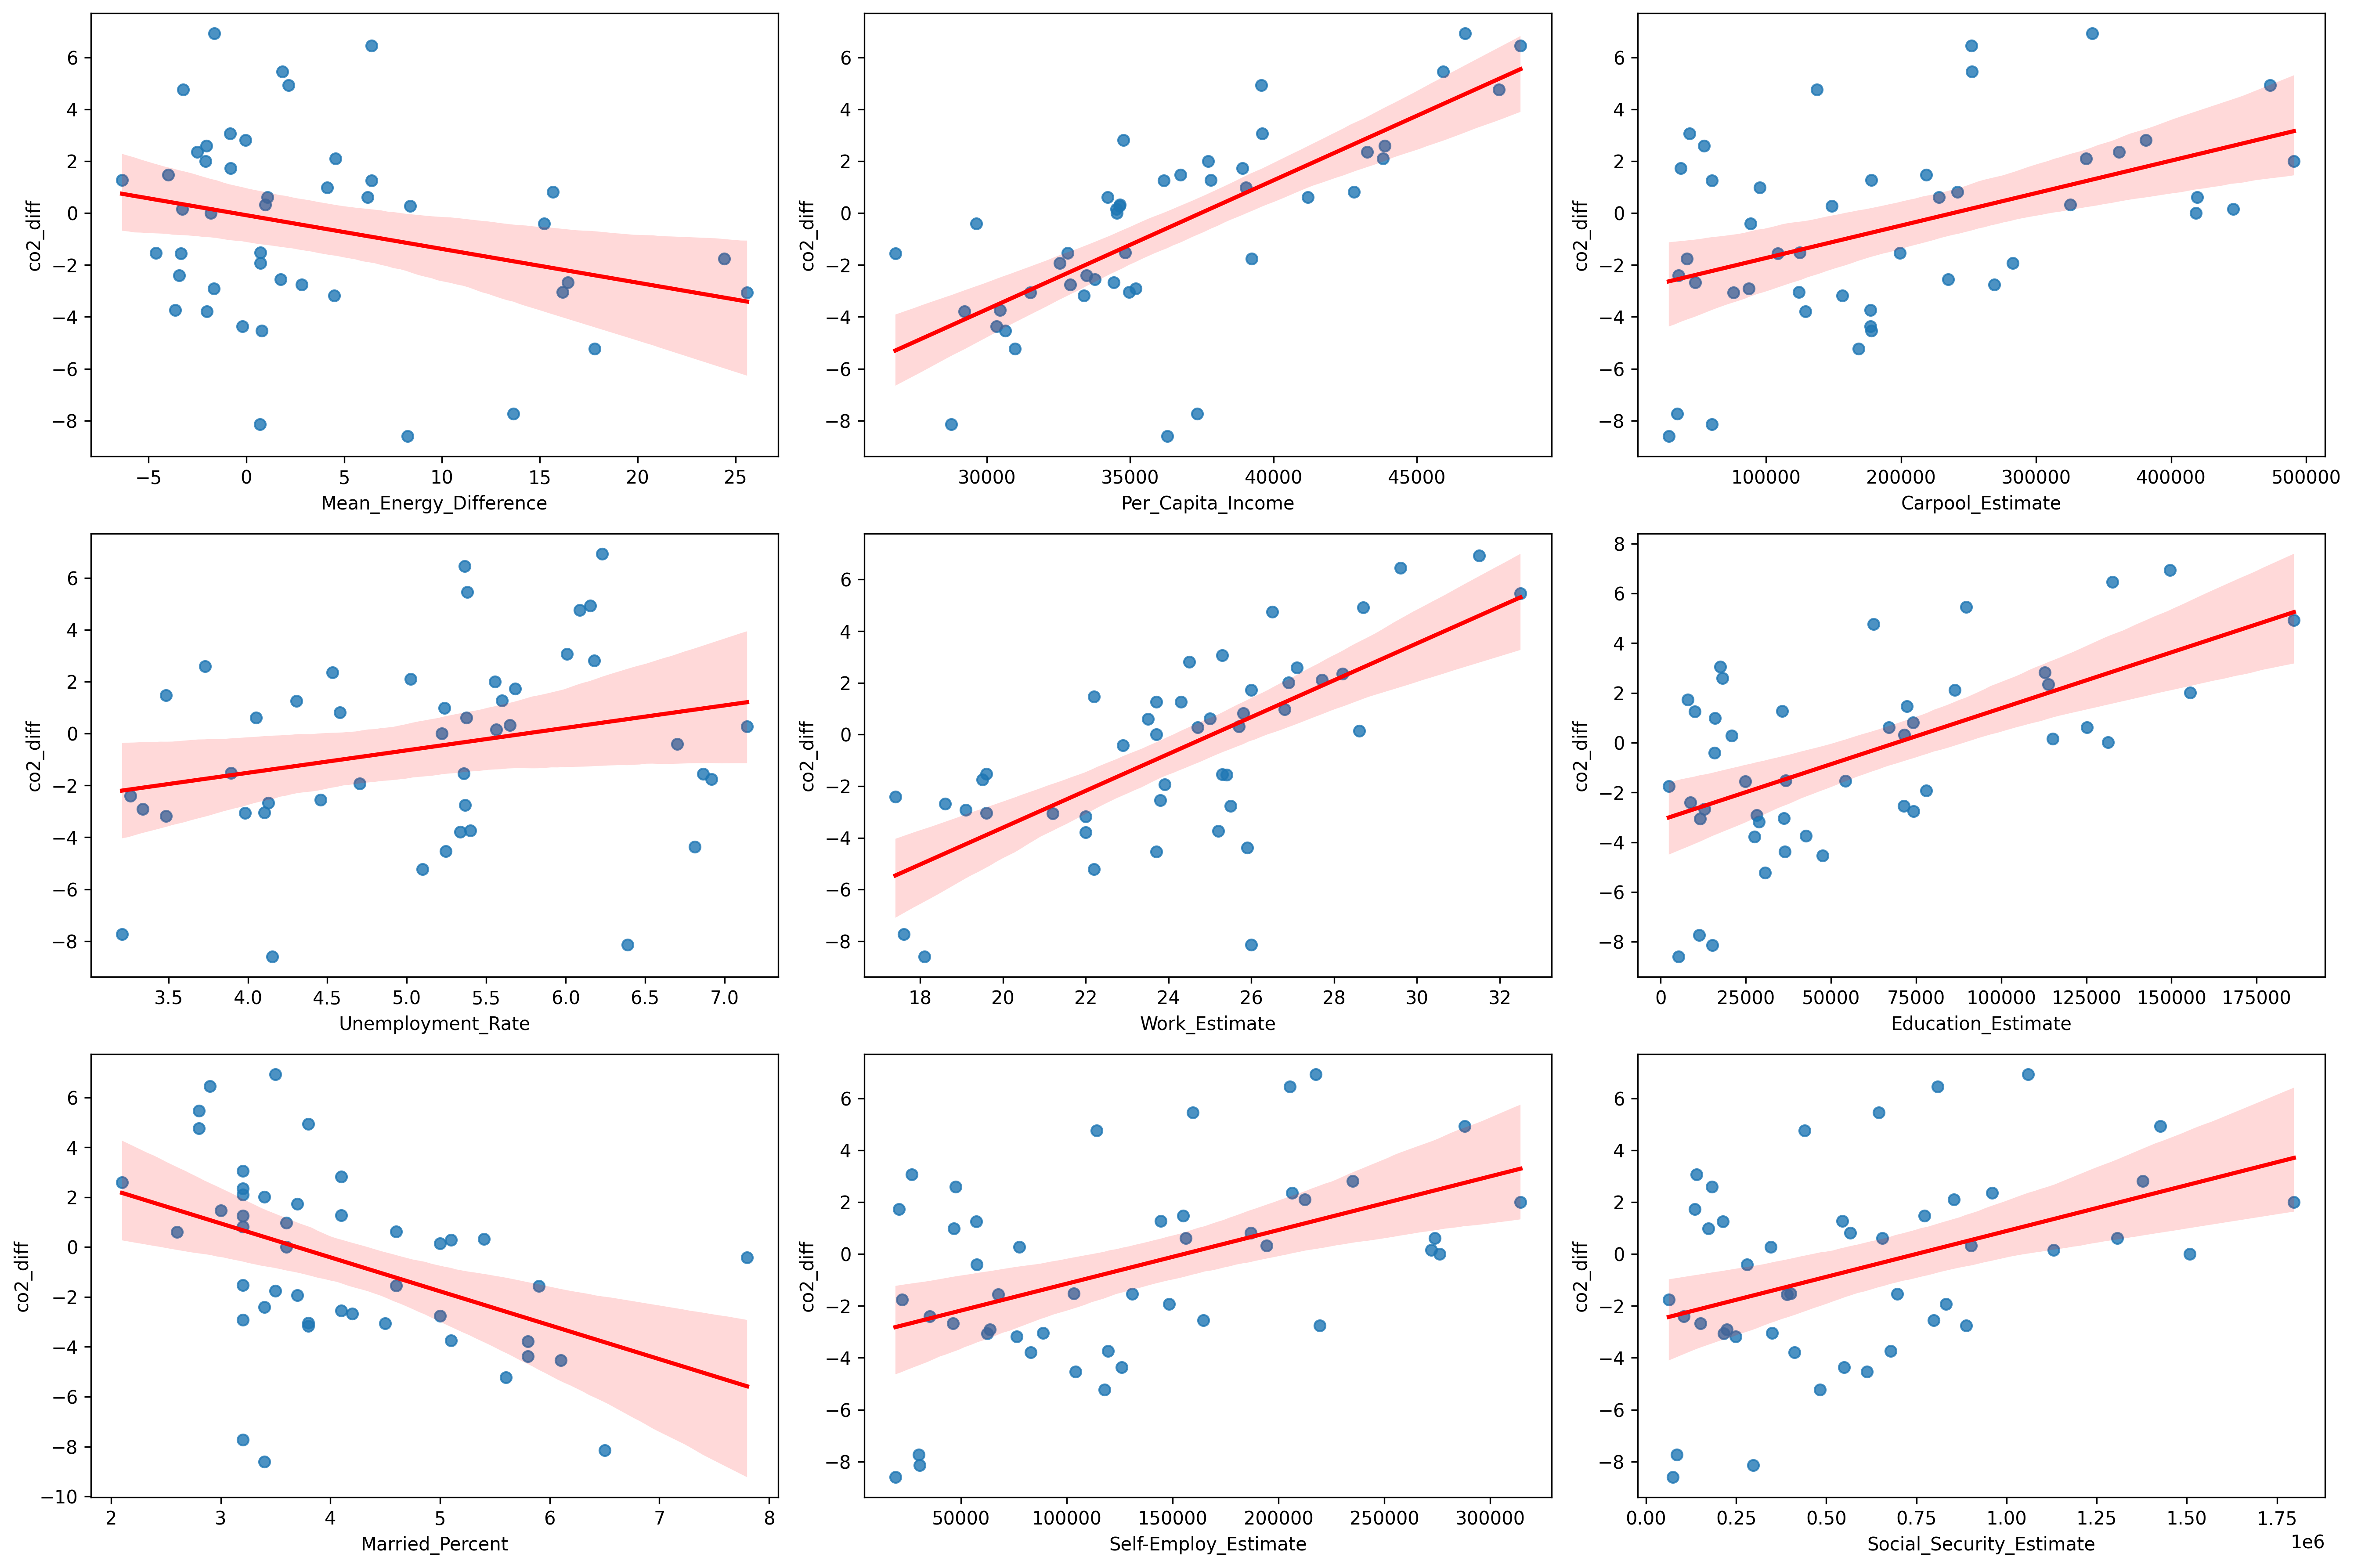

In [71]:
# Removing outliers from Carpool_Estimate, Education_Estimate, and Self-Employ_Estimate
# We'll use the IQR method to filter out the outliers from these columns

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Applying the outlier removal function to the specified columns
filtered_data = plot_data.copy()
for column in [
    'difference',
    'Per_Capita_Income',
    'Carpool_Estimate',
    'Unemployment_Rate',
    'Work_Estimate',
    'Education_Estimate',
    'Married_Percent',
    'Self-Employ_Estimate',
    'Social_Security_Estimate'
]:
    filtered_data = remove_outliers(filtered_data, column)

# Now let's plot the regression lines again without the outliers
plt.figure(figsize=(18, 12), dpi=300)

for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.regplot(x=feature, y=target, data=filtered_data, line_kws={"color": "red"})
    # plt.title(feature)
    if feature == 'difference':
        plt.xlabel("Mean_Energy_Difference")

plt.tight_layout()
plt.show()


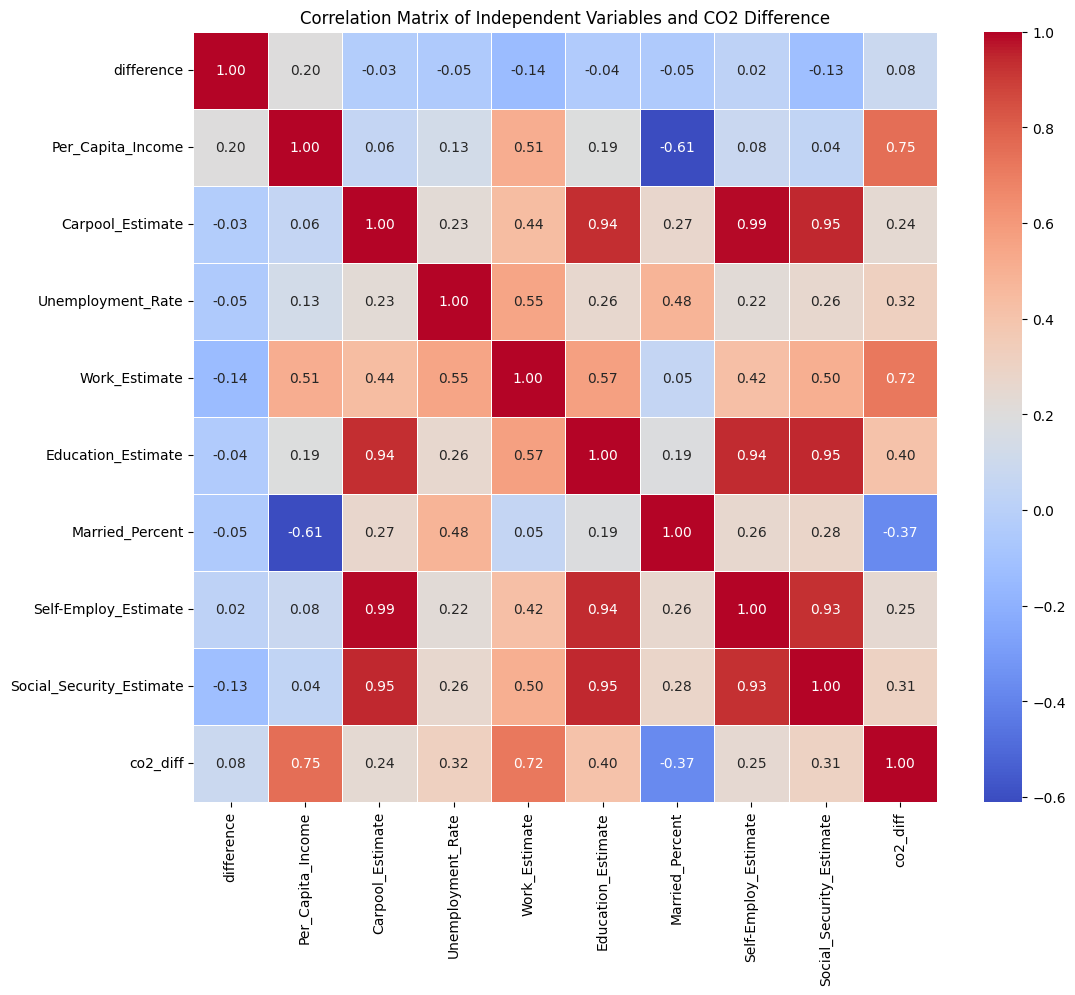

In [72]:
# Creating a correlation matrix of all the independent variables and the dependent variable
correlation_matrix = plot_data[features + [target]].corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix of Independent Variables and CO2 Difference")
plt.show()